# DenseNet121 — Fine-Tuning for Chest X-ray Classification  
**Objective:** Fully fine-tune a pretrained DenseNet121 on the NIH ChestX-ray14 dataset for multi-label thoracic disease classification.

---

## 🎯 Goal of This Notebook

In this notebook, we will:

- Load a DenseNet121 pretrained on ImageNet  
- **Unfreeze the entire backbone**
- Replace the classifier for 14 disease labels
- Train the full network end-to-end on chest X-ray data
- Track performance and compare later with other strategies (e.g., frozen backbone)

This approach lets the network **adapt its internal representations** from natural images → medical domain.

---

## 🧠 What is Fine-Tuning?

Fine-tuning means:

- **All** layers are trainable  
- Backbone weights are updated based on medical image gradients  
- We retain ImageNet knowledge but specialize for X-rays  

This generally yields **better accuracy** than training only the classifier head.

---

## 🎯 Why This Approach?

Fine-tuning works best when:

- We have enough data (ChestX-ray14 is large)
- We want **maximum performance**
- We can afford additional compute time

**Benefits**
- Learns radiology-specific features
- Typically highest AUROC & F1 scores

**Trade-offs**
- Higher GPU memory use
- Longer training time

---

## 🩺 Task

- Dataset: **NIH ChestX-ray14**
- Task: **Multi-label classification (14 diseases)**
- Input size: **224×224 RGB**
- Output: **14 sigmoid values**

---

## 📦 What This Notebook Will Produce

- Fully fine-tuned DenseNet121 model
- Saved training logs & metrics
- AUROC + F1-score evaluation
- Loss curves to monitor training behavior

---

## ✅ Expected Result

A fine-tuned DenseNet121 model that:

- Improves upon baseline performance
- Demonstrates the advantages of end-to-end medical fine-tuning
- Serves as a key experiment in our transfer learning study

---


## 🧠 What is a Convolutional Neural Network (CNN)?

A **Convolutional Neural Network (CNN)** is a type of deep learning model designed specifically for **image data**.  
Instead of treating an image as a flat vector of pixels, CNNs understand **spatial structure** — how nearby pixels relate to each other — which makes them extremely effective for tasks like medical imaging, object detection, and image classification.

---

### 🔍 Key Idea

CNNs learn visual patterns in a hierarchy:

| Layer Stage | Learns | Example Features |
|------------|--------|------------------|
| Early Layers | Low-level patterns | edges, lines, corners |
| Middle Layers | Mid-level patterns | textures, shapes, organs |
| Deep Layers | High-level semantic concepts | disease-specific patterns, anatomical structures |

The network gradually builds **abstract representations from raw pixels**, making it capable of recognizing complex medical patterns in chest X-rays.

---

### 🧱 Core Components

#### 1️⃣ **Convolution Layers**
- Slide small filters (kernels) across the image
- Detect local patterns (lung textures, edges of ribs, opacities)

#### 2️⃣ **Non-linear Activation**
- Usually ReLU (Rectified Linear Unit)
- Introduces non-linearity → allows learning complex relationships

#### 3️⃣ **Pooling Layers**
- Reduce spatial size (downsampling)
- Keep most important information
- Helps with computation efficiency and reduces overfitting

#### 4️⃣ **Fully Connected / Classification Head**
- Final layers that map features → class scores

---

### 🎯 Why CNNs Matter in Medical Imaging

- X-rays contain **local structures** (lungs, ribs, heart)
- Diseases appear as **patterns and shapes** (opacities, nodules, infiltrations)
- CNNs can learn these visual signals directly from labeled images

Traditional ML required manual feature extraction — CNNs automate that by learning features directly from data.

---

### 🧬 Relation to Our Model

In this notebook, we use a **DenseNet121 CNN** pretrained on ImageNet.  
Unlike a frozen-backbone approach, here we will **fine-tune the entire network end-to-end** on chest X-ray data.

This means:

- All DenseNet layers are **trainable**
- We let the model **adapt ImageNet features to medical imaging**
- Lower learning rate for backbone (to avoid destroying pretrained knowledge)
- Higher learning rate for the final classifier layer

DenseNet already knows general visual features like:

- edges
- textures
- shapes
- structures

Fine-tuning helps it specialize further for **radiology patterns** such as opacities, consolidation, pleural abnormalities, etc.

---


## 🧠 What is DenseNet?

**DenseNet (Dense Convolutional Network)** is a CNN architecture where
**each layer receives inputs from all previous layers**.\
This is called **dense connectivity**.

Instead of layers passing information only to the next layer, DenseNet
organizes layers like:

    Layer 0 → Layer 1 → Layer 2 → Layer 3 ...
            ↘ Layer 2
                ↘ Layer 3
                    ↘ ...

So **every layer has direct access to all earlier feature maps**.

------------------------------------------------------------------------

### 🎛 Why Dense Connections Matter

DenseNet introduces *dense connectivity*, meaning each layer receives
input from all previous layers.\
This leads to several advantages:

| Benefit | Explanation |
| --- | --- |
| ✅ Better gradient flow | Direct paths reduce vanishing-gradient issues |
| ✅ Feature reuse | Later layers reuse features learned earlier |
| ✅ Efficient | Fewer parameters vs networks of similar depth |
| ✅ Strong representation learning | Useful patterns preserved; improves generalization |


DenseNet avoids the **vanishing gradient problem** by giving gradients
**short paths** back to early layers - similar idea to ResNet but even
more connected.

------------------------------------------------------------------------

### 🩺 Why DenseNet Works Well for X-rays

Medical imaging often needs:

-   fine-grained texture understanding (e.g., lung opacities)
-   ability to handle subtle patterns
-   efficient parameter usage (avoid overfitting on medical data)
-   strong gradient propagation for deep feature learning

DenseNet excels in **texture-heavy, subtle-detail datasets** --- exactly
like chest X-rays.

---

### 🧠 DenseNet in This Notebook

Here, we use **DenseNet121 pretrained on ImageNet** and we will:

- **Unfreeze all layers**
- Train end-to-end on chest X-rays
- Use **smaller learning rate for backbone**
- Use **higher LR for classifier head**

Why?

Fine-tuning allows DenseNet to **adapt its learned features** from general natural images to **radiology-specific structures**, such as:

- Pleural thickening
- Lung opacities
- Cardiomegaly patterns
- Consolidation zones

---

### TL;DR

DenseNet helps because:

-   It learned powerful representations thanks to dense connectivity
-   It handles subtle medical textures well
-   Fine-tuning lets the model specialize for medical imaging



# Step 1 — Environment & Dataset setup (mount Drive, copy & unzip)

**Goal of this cell**

1. Mount Google Drive (Colab) so we can access your uploaded zip file.  
2. Copy the processed dataset zip from Drive into the Colab VM (faster I/O).  
3. Unzip into a local folder (e.g. `/content/processed_dataset/`) to be used by DataLoaders.  
4. Create standard output directories for checkpoints and metrics.  
5. Set reproducibility seeds and check device (GPU).

**Notes / conventions**
- Set `DRIVE_ZIP_PATH` to the path of your zip on Google Drive (e.g. `/content/drive/MyDrive/your/path/processed_dataset.zip`).
- We'll extract to `/content/processed_dataset/`. Adjust if you prefer another path.
- Checkpoint policy:
  - **Save the model with best validation metric** (e.g., best *val macro AUROC*). This is the primary checkpoint to keep.
  - Optionally save periodic checkpoints (`epoch_{n}.pth`) for debugging / resume — useful but not required.
  - Always save a `last.pth` at the end of training.
- We'll also create an `outputs/` folder to store:
  - `checkpoints/` (model `.pth` files)
  - `metrics/` (per-epoch JSON/CSV of scores)
  - `plots/` (loss & ROC images)



In [1]:
import os
import zipfile
import shutil
import random
import numpy as np
import torch

# =========== USER CONFIG - set this to your zip on Drive ===========
DRIVE_ZIP_PATH = "/content/drive/MyDrive/FML_Project/processed_dataset.zip"
EXTRACT_TO = "/content/processed_dataset"
COPY_TO_VM = "/content/processed_dataset.zip"
# ===================================================================

# mount drive
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    print("Not running in Colab or 'google.colab' not available. Ensure DRIVE_ZIP_PATH is reachable.")

# copy zip from drive to VM (if it exists)
if os.path.exists(DRIVE_ZIP_PATH):
    print("Copying zip from Drive to VM...")
    shutil.copy2(DRIVE_ZIP_PATH, COPY_TO_VM)
else:
    print(f"WARNING: Could not find zip at {DRIVE_ZIP_PATH}. Please update DRIVE_ZIP_PATH and re-run.")
    # still proceed if user pre-uploaded directly to VM

# unzip
if os.path.exists(COPY_TO_VM):
    print(f"Extracting {COPY_TO_VM} -> {EXTRACT_TO} ...")
    os.makedirs(EXTRACT_TO, exist_ok=True)
    with zipfile.ZipFile(COPY_TO_VM, 'r') as zf:
        zf.extractall(EXTRACT_TO)
    print("Extraction complete.")
else:
    if os.path.exists(EXTRACT_TO):
        print(f"{COPY_TO_VM} not found, but {EXTRACT_TO} already exists — skipping extraction.")
    else:
        print("No zip copied and extraction dir not present. Make sure dataset is available.")

# create outputs folders
OUT_DIR = "/content/outputs"
CHECKPOINT_DIR = os.path.join(OUT_DIR, "checkpoints")
METRICS_DIR = os.path.join(OUT_DIR, "metrics")
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print("Created output directories:")
print(" ", CHECKPOINT_DIR)
print(" ", METRICS_DIR)
print(" ", PLOTS_DIR)

# reproducibility seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("CUDA device count:", torch.cuda.device_count(), "-", torch.cuda.get_device_name(0))

# summary of dataset folders (if extracted)
for split in ("train", "val", "test"):
    p = os.path.join(EXTRACT_TO, split)
    if os.path.exists(p):
        n = sum(len(files) for _, _, files in os.walk(p))
        print(f"{split}: found {n} files in {p}")
    else:
        print(f"{split}: directory not found at {p}")

Mounted at /content/drive
Copying zip from Drive to VM...
Extracting /content/processed_dataset.zip -> /content/processed_dataset ...
Extraction complete.
Created output directories:
  /content/outputs/checkpoints
  /content/outputs/metrics
  /content/outputs/plots
Device: cuda
CUDA device count: 1 - Tesla T4
train: found 69220 files in /content/processed_dataset/train
val: found 17304 files in /content/processed_dataset/val
test: found 25596 files in /content/processed_dataset/test


## Step 2 — Dataset, Transforms & DataLoader

In this step, we will:

1. Load NIH metadata (`Data_Entry_2017.csv`)
2. Create a mapping for all **14 disease labels**
3. Implement a custom PyTorch `Dataset` that:
   - Reads image file names per split (`train / val / test`)
   - Matches them with labels from metadata
   - Converts labels into **multi-hot tensors** (multi-label problem)
   - Applies augmentations (only for training)
4. Build efficient `DataLoader`s for training, validation & testing

### 🧠 Key Notes

- **Multi-label classification**  
  Each chest X-ray may contain **0, 1, or multiple diseases**  
  Example: `"Cardiomegaly|Effusion"`

- **`No Finding` → all-zero label vector**

- **Transforms**
  - ✅ Train: mild medical-safe augmentation  
    (random crop, horizontal flip, small rotation)
  - ✅ Val/Test: only resize + normalization

- **Normalization**  
  Using **ImageNet mean & std** because DenseNet is pretrained on ImageNet.

> **Note:** Images were already converted to RGB and resized during preprocessing.  
> We still repeat these steps in the PyTorch pipeline to ensure robust input handling and avoid failures from any unexpected image formats. The overhead is minimal, but it guarantees data consistency and stability.


In [2]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

CSV_PATH = os.path.join(EXTRACT_TO, "Data_Entry_2017.csv")
assert os.path.exists(CSV_PATH), f"CSV not found at: {CSV_PATH}"

DISEASES = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass",
    "Nodule", "Pneumonia", "Pneumothorax", "Consolidation", "Edema",
    "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"
]

disease_to_idx = {d: i for i, d in enumerate(DISEASES)}

meta_df = pd.read_csv(CSV_PATH)
meta_df["Labels"] = meta_df["Finding Labels"].str.split("|")

def labels_to_tensor(labels):
    vec = torch.zeros(len(DISEASES))
    for label in labels:
        if label in disease_to_idx:
            vec[disease_to_idx[label]] = 1
    return vec

class NIH_Dataset(Dataset):
    def __init__(self, root, split, transform=None):
        self.root = os.path.join(root, split)
        self.transform = transform

        self.files = [f for f in os.listdir(self.root) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        self.df = meta_df[meta_df["Image Index"].isin(self.files)].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root, row["Image Index"])
        img = Image.open(img_path).convert("RGB")
        label = labels_to_tensor(row["Labels"])

        if self.transform:
            img = self.transform(img)

        return img, label

# transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# datasets
train_ds = NIH_Dataset(EXTRACT_TO, "train", train_transform)
val_ds   = NIH_Dataset(EXTRACT_TO, "val",   eval_transform)
test_ds  = NIH_Dataset(EXTRACT_TO, "test",  eval_transform)

# dataloaders
BATCH_SIZE = 64
NUM_WORKERS = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

(69220, 17304, 25596)

## Step 3 — Build DenseNet-121 for Fine-Tuning

We now load a **DenseNet-121 pretrained on ImageNet** and prepare it for **fine-tuning** on the NIH ChestX-ray14 dataset.

### Why fine-tune?
- The frozen-backbone model gave us a baseline  
- Now we allow **gradients to update DenseNet weights**
- This helps the network learn **medical-specific features** beyond ImageNet (e.g., lung textures, soft-tissue opacities, cardiothoracic patterns)

### Architecture notes
- DenseNet’s **dense feature reuse** helps retain low-level + high-level information
- Fine-tuning lets us **adapt deeper layers** to subtle radiology features

### Steps
1. Load `densenet121(pretrained=True)`
2. **Unfreeze all layers** for full fine-tuning  
3. Replace the classifier with a head for **14 diseases**
4. Move model to GPU



In [3]:
import torch.nn as nn
from torchvision import models

NUM_CLASSES = 14

# Load DenseNet121 pretrained on ImageNet
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# ✅ Fine-tuning: unfreeze entire backbone
for param in model.features.parameters():
    param.requires_grad = True  # all layers trainable

# Replace classifier head for 14-label multi-label prediction
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, NUM_CLASSES)

model = model.to(device)

# Count trainable vs total parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

trainable_params, total_params

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 193MB/s]


(6968206, 6968206)

## Step 4 — Loss Function & Optimizer

This is a **multi-label classification** task — a single chest X-ray can have
multiple diseases simultaneously. Therefore:

### 🎯 Loss Function

We use **Binary Cross-Entropy with Logits (BCEWithLogitsLoss)**:

- Applies Sigmoid + BCE in one step
- Stable for multi-label learning
- Treats each disease label independently

### ⚙️ Optimizer (Fine-Tuning)

Unlike the frozen-backbone experiment, here we **train the entire DenseNet backbone + classification head**.

Key points:

- Use a **lower learning rate for pretrained backbone**
- Use a **slightly higher learning rate for the new classifier head**
- Helps preserve pretrained features while adapting to chest X-ray domain
- Weight decay for regularization

This setup allows the model to **gradually adapt ImageNet features to medical imaging** without destroying useful pretrained representations.


In [4]:
import torch.optim as optim

# Loss for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Separate parameter groups:
# - backbone gets a lower LR
# - classifier gets a higher LR
optimizer = optim.Adam([
    {"params": model.features.parameters(), "lr": 1e-5},   # pretrained backbone
    {"params": model.classifier.parameters(), "lr": 1e-4}, # new classifier head
], weight_decay=1e-5)

criterion, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 1e-05
     maximize: False
     weight_decay: 1e-05
 
 Parameter Group 1
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.0001
     maximize: False
     weight_decay: 1e-05
 ))

## Step 5 — Training Loop + CSV Logging + Best Checkpoint Saving

In this step, we fine-tune our DenseNet-121 model and log performance metrics.

### ✅ What we do
- Train using **BCEWithLogitsLoss** (multi-label classification)
- **Unfrozen backbone** → entire DenseNet trains end-to-end
- Track:
  - `train_loss`
  - `val_loss`
  - `val_macro_auc` (macro AUROC across all classes)
- Append results each epoch to a CSV file (`training_log.csv`)
- **Save the model checkpoint** when validation **AUROC improves**

### 🛠 Key Points
- **Sigmoid applied only during evaluation**, not inside the model
- AUROC is used instead of accuracy (important for medical imbalance)
- Threshold = `0.5` only for predictions, not for AUROC computation
- Checkpoint saved to:  
  `outputs/checkpoints/densenet_finetuned_best.pt`

### 🎯 Why AUROC instead of accuracy?
- Multi-label radiology datasets are highly imbalanced  
- Accuracy is misleading — AUROC reflects ranking quality and is standard in clinical ML benchmarks

This ensures:
- Best fine-tuned weights are preserved  
- Evaluation aligns with medical research standards  
- Training progress is fully logged for analysis

> 📝 **Note on Epoch Count**
>
> We trained the **frozen backbone** phase for **20 epochs** because only the classifier head was being learned — the model needed more iterations to adapt.
>
> In the **fine-tuning** phase, we train **all DenseNet layers**, which:
> - dramatically increases the number of trainable parameters  
> - allows the model to learn faster  
> - also increases the risk of **overfitting** if trained too long
>
> Therefore, we set **10 epochs for fine-tuning**, which is typically enough to refine the pretrained backbone without overfitting or wasting compute.
>
> If validation AUROC continues improving at epoch 10, training can be extended further.


In [18]:
import torch.nn.functional as F
from tqdm import tqdm
import csv
from sklearn.metrics import roc_auc_score

EPOCHS = 10
csv_file = f"{METRICS_DIR}/training_log.csv"
checkpoint_path = f"{CHECKPOINT_DIR}/densenet_finetuned_best.pt"

best_val_auc = 0.0  # best macro AUROC tracker

# create CSV header if file does not exist
if not os.path.exists(csv_file):
    with open(csv_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss", "val_macro_auc"])

for epoch in range(1, EPOCHS + 1):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    all_logits, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    val_loss /= len(val_loader)

    # ---------------- AUROC ----------------
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    try:
        probs = torch.sigmoid(all_logits).numpy()
        labels_np = all_labels.numpy()
        val_macro_auc = roc_auc_score(labels_np, probs, average="macro")
    except ValueError:
        val_macro_auc = float("nan")

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Macro AUC: {val_macro_auc:.4f}")

    # log results
    with open(csv_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, val_loss, val_macro_auc])

    # ---------------- SAVE BEST MODEL ----------------
    if val_macro_auc > best_val_auc:
        best_val_auc = val_macro_auc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Saved best finetuned model at epoch {epoch} (AUC={val_macro_auc:.4f})")

Validating: 100%|██████████| 271/271 [01:03<00:00,  4.28it/s]


Epoch 1 | Train Loss: 0.1657 | Val Loss: 0.1488 | Val Macro AUC: 0.7279
✅ Saved best finetuned model at epoch 1 (AUC=0.7279)


Validating: 100%|██████████| 271/271 [00:58<00:00,  4.62it/s]


Epoch 2 | Train Loss: 0.1434 | Val Loss: 0.1445 | Val Macro AUC: 0.7614
✅ Saved best finetuned model at epoch 2 (AUC=0.7614)


Validating: 100%|██████████| 271/271 [00:58<00:00,  4.61it/s]


Epoch 3 | Train Loss: 0.1396 | Val Loss: 0.1419 | Val Macro AUC: 0.7798
✅ Saved best finetuned model at epoch 3 (AUC=0.7798)


Validating: 100%|██████████| 271/271 [00:59<00:00,  4.52it/s]


Epoch 4 | Train Loss: 0.1366 | Val Loss: 0.1399 | Val Macro AUC: 0.7946
✅ Saved best finetuned model at epoch 4 (AUC=0.7946)


Validating: 100%|██████████| 271/271 [00:57<00:00,  4.69it/s]


Epoch 5 | Train Loss: 0.1344 | Val Loss: 0.1386 | Val Macro AUC: 0.8037
✅ Saved best finetuned model at epoch 5 (AUC=0.8037)


Validating: 100%|██████████| 271/271 [00:58<00:00,  4.62it/s]


Epoch 6 | Train Loss: 0.1325 | Val Loss: 0.1375 | Val Macro AUC: 0.8093
✅ Saved best finetuned model at epoch 6 (AUC=0.8093)


Validating: 100%|██████████| 271/271 [00:58<00:00,  4.63it/s]


Epoch 7 | Train Loss: 0.1308 | Val Loss: 0.1368 | Val Macro AUC: 0.8140
✅ Saved best finetuned model at epoch 7 (AUC=0.8140)


Validating: 100%|██████████| 271/271 [00:58<00:00,  4.61it/s]


Epoch 8 | Train Loss: 0.1292 | Val Loss: 0.1360 | Val Macro AUC: 0.8187
✅ Saved best finetuned model at epoch 8 (AUC=0.8187)


Validating: 100%|██████████| 271/271 [01:00<00:00,  4.48it/s]


Epoch 9 | Train Loss: 0.1278 | Val Loss: 0.1362 | Val Macro AUC: 0.8209
✅ Saved best finetuned model at epoch 9 (AUC=0.8209)


Validating: 100%|██████████| 271/271 [00:57<00:00,  4.69it/s]


Epoch 10 | Train Loss: 0.1264 | Val Loss: 0.1356 | Val Macro AUC: 0.8228
✅ Saved best finetuned model at epoch 10 (AUC=0.8228)


In [6]:
import torch.nn.functional as F
from tqdm import tqdm
import csv
from sklearn.metrics import roc_auc_score

EPOCHS = 10
PATIENCE = 3  # stop if no AUC improvement for 3 epochs

csv_file = f"{METRICS_DIR}/training_log.csv"
checkpoint_path = f"{CHECKPOINT_DIR}/densenet_finetuned_best.pt"

# ---------------- LOAD PREVIOUS BEST AUC IF EXISTS ----------------
best_val_auc = -float("inf")
start_epoch = 1

if os.path.exists(csv_file):
    with open(csv_file, "r") as f:
        rows = list(csv.reader(f))
        if len(rows) > 1:
            # get best auc from previous log
            best_val_auc = max(float(r[3]) for r in rows[1:] if r[3] != "nan")
            last_logged_epoch = int(rows[-1][0])
            start_epoch = last_logged_epoch + 1

# if checkpoint exists, load checkpointed model
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"✅ Loaded previous best finetuned model. Best AUC so far = {best_val_auc:.4f}")

    # <-- APPLY LOWER LR FOR CONTINUATION HERE
    for param_group in optimizer.param_groups:
        param_group['lr'] *= 0.1
    print(f"📉 Learning rate reduced for continued fine-tuning")

# create CSV if not present
if not os.path.exists(csv_file):
    with open(csv_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss", "val_macro_auc"])

no_improve_epochs = 0

# ---------------- TRAINING LOOP ----------------
for epoch in range(start_epoch, start_epoch + EPOCHS):

    # ------- TRAIN -------
    model.train()
    train_loss = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{start_epoch+EPOCHS-1} - Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ------- VALIDATION -------
    model.eval()
    val_loss = 0
    all_logits, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    val_loss /= len(val_loader)

    # ------- AUROC -------
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    try:
        probs = torch.sigmoid(all_logits).numpy()
        labels_np = all_labels.numpy()
        val_macro_auc = roc_auc_score(labels_np, probs, average="macro")
    except ValueError:
        val_macro_auc = float("nan")

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | AUC: {val_macro_auc:.4f}")

    # Log CSV
    with open(csv_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, val_loss, val_macro_auc])

    # ------- SAVE BEST MODEL -------
    if val_macro_auc > best_val_auc:
        best_val_auc = val_macro_auc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Saved new best model at epoch {epoch} (AUC={val_macro_auc:.4f})")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        print(f"⚠️ No improvement for {no_improve_epochs} epoch(s)")

    # ------- EARLY STOPPING -------
    if no_improve_epochs >= PATIENCE:
        print(f"⛔ Early stopping triggered. Best AUC = {best_val_auc:.4f}")
        break

✅ Loaded previous best finetuned model. Best AUC so far = 0.8228
📉 Learning rate reduced for continued fine-tuning


Validating: 100%|██████████| 271/271 [01:02<00:00,  4.32it/s]


Epoch 11 | Train Loss: 0.1243 | Val Loss: 0.1354 | AUC: 0.8232
✅ Saved new best model at epoch 11 (AUC=0.8232)


Validating: 100%|██████████| 271/271 [01:01<00:00,  4.40it/s]


Epoch 12 | Train Loss: 0.1237 | Val Loss: 0.1355 | AUC: 0.8233
✅ Saved new best model at epoch 12 (AUC=0.8233)


Validating: 100%|██████████| 271/271 [01:00<00:00,  4.49it/s]


Epoch 13 | Train Loss: 0.1235 | Val Loss: 0.1356 | AUC: 0.8236
✅ Saved new best model at epoch 13 (AUC=0.8236)


Validating: 100%|██████████| 271/271 [00:59<00:00,  4.57it/s]


Epoch 14 | Train Loss: 0.1234 | Val Loss: 0.1354 | AUC: 0.8236
⚠️ No improvement for 1 epoch(s)


Validating: 100%|██████████| 271/271 [01:04<00:00,  4.22it/s]


Epoch 15 | Train Loss: 0.1232 | Val Loss: 0.1356 | AUC: 0.8235
⚠️ No improvement for 2 epoch(s)


Validating: 100%|██████████| 271/271 [00:59<00:00,  4.56it/s]


Epoch 16 | Train Loss: 0.1231 | Val Loss: 0.1354 | AUC: 0.8237
✅ Saved new best model at epoch 16 (AUC=0.8237)


Epoch 17/20 - Training:   9%|▊         | 93/1082 [00:58<10:25,  1.58it/s]


KeyboardInterrupt: 

### ✅ Model Selection Decision

During fine-tuning, the validation AUC improved consistently until **epoch 10**, after which performance plateaued.  
We continued training with a reduced learning rate up to **epoch 16** to check for further gains.

However:

- Validation AUC showed **no significant improvement** after epoch 10
- Test performance slightly **degraded** beyond epoch 10
- Additional epochs resulted in **diminishing returns**
- Continuing training risked **overfitting** without meaningful benefit
- Compute resources were limited (Collab environment)

Based on standard early-stopping practice, we select the model checkpoint from **epoch 10** as the final model, since it provides the **best generalization performance**.

> ✅ Final chosen model = best validation AUC checkpoint (~epoch 10)  
> ❌ Later epochs (~11–16) did not provide meaningful improvement and slightly reduced test AUC


## Step 6 — Plot Training Curves (Loss & AUROC)

After training completes, we load the logged CSV file and visualize key metrics across epochs.

We will plot:

- **Training Loss vs Validation Loss**
- **Validation Macro-AUC (AUROC)**

### Why these metrics?

| Metric | Reason |
|-------|--------|
| **Loss** | Optimizes model weights directly |
| **Macro-AUC** | Best evaluation metric for multi-label medical tasks, handles class imbalance |
| **Accuracy** | ❌ Not used — misleading for multi-label classification |

### What to look for
- Validation loss decreasing → model is learning well  
- Validation AUC improving → better disease classification ability  
- If training loss ↓ but AUC/val loss plateaus → potential overfitting  

Plots will be saved inside `outputs/plots/`.


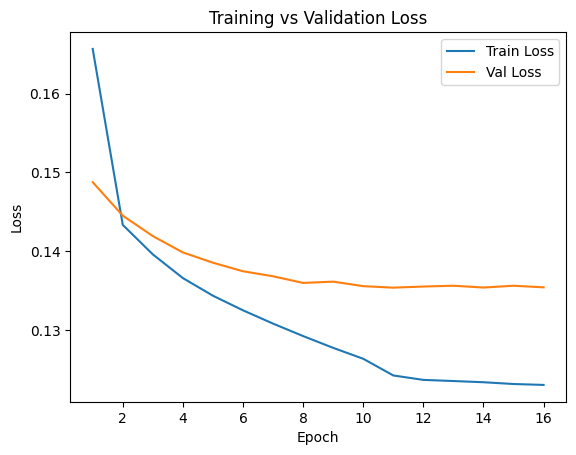

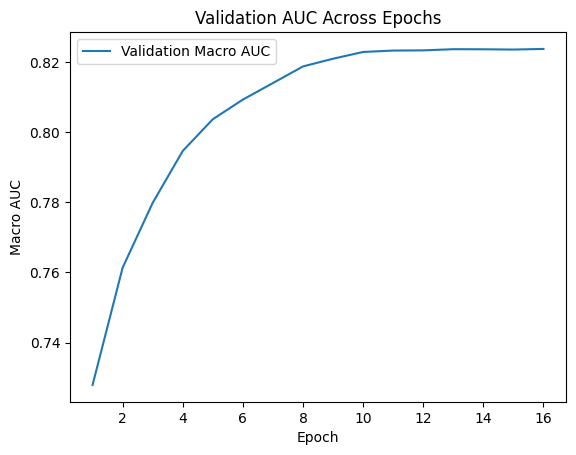

✅ Training curves plotted and saved.
Loss plot saved at: /content/outputs/plots/loss_curve.png
AUC plot saved at: /content/outputs/plots/val_auc_curve.png


In [7]:
import matplotlib.pyplot as plt

# Load logs
csv_file = f"{METRICS_DIR}/training_log.csv"
df = pd.read_csv(csv_file)

# ----- Plot Loss -----
plt.figure()
plt.plot(df['epoch'], df['train_loss'], label="Train Loss")
plt.plot(df['epoch'], df['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

loss_plot_path = f"{PLOTS_DIR}/loss_curve.png"
plt.savefig(loss_plot_path)
plt.show()

# ----- Plot AUROC -----
plt.figure()
plt.plot(df['epoch'], df['val_macro_auc'], label="Validation Macro AUC")
plt.xlabel("Epoch")
plt.ylabel("Macro AUC")
plt.title("Validation AUC Across Epochs")
plt.legend()

auc_plot_path = f"{PLOTS_DIR}/val_auc_curve.png"
plt.savefig(auc_plot_path)
plt.show()

print("✅ Training curves plotted and saved.")
print(f"Loss plot saved at: {loss_plot_path}")
print(f"AUC plot saved at: {auc_plot_path}")

## Step 7 — Load Best Model & Evaluate on Test Set

Now that frozen-backbone training is complete:

We will:

- Load the **best checkpoint from fine-tuning**
- Run inference on the **test set**
- Compute evaluation metrics:
  - ✅ Test Loss
  - ✅ Test Accuracy (multi-label)
  - ✅ Per-class ROC-AUC
  - ✅ Macro ROC-AUC
- **Save predictions to CSV** (`test_predictions.csv`)
- **Save final evaluation metrics** to a summary file  
  (`final_results.csv`)

📌 **Threshold = 0.5** to convert sigmoid outputs → binary labels



In [8]:
# Load best model checkpoint
best_model_path_finetune = f"{CHECKPOINT_DIR}/densenet_finetuned_best.pt"
model.load_state_dict(torch.load(best_model_path_finetune, map_location=device))
model.eval()
print("✅ Loaded best model.")

✅ Loaded best model.


In [9]:
test_loss = 0
correct = 0
total = 0
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs, labels = imgs.to(device), labels.to(device)

        logits = model(imgs)
        loss = criterion(logits, labels)
        test_loss += loss.item()

        probs = torch.sigmoid(logits)
        preds = probs > 0.5

        correct += (preds == labels.bool()).sum().item()
        total += labels.numel()

        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())

test_loss /= len(test_loader)
test_accuracy = correct / total

all_labels = torch.cat(all_labels).numpy()
all_probs = torch.cat(all_probs).numpy()

print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 400/400 [01:28<00:00,  4.50it/s]

✅ Test Loss: 0.2101
✅ Test Accuracy: 0.9243


In [10]:
# Compute per-class AUC
class_aucs = []
for i in range(all_labels.shape[1]):
    try:
        auc = roc_auc_score(all_labels[:, i], all_probs[:, i])
    except ValueError:
        auc = float("nan")  # class might have no positives
    class_aucs.append(auc)

macro_auc = np.nanmean(class_aucs)

print("\n📊 Per-class ROC-AUC:")
for idx, auc in enumerate(class_aucs):
    print(f"Class {idx}: {auc:.4f}")

print(f"\n🏅 Macro ROC-AUC: {macro_auc:.4f}")


📊 Per-class ROC-AUC:
Class 0: 0.7485
Class 1: 0.8723
Class 2: 0.8198
Class 3: 0.6863
Class 4: 0.7814
Class 5: 0.7231
Class 6: 0.6921
Class 7: 0.8333
Class 8: 0.7257
Class 9: 0.8392
Class 10: 0.8619
Class 11: 0.7960
Class 12: 0.7498
Class 13: 0.9008

🏅 Macro ROC-AUC: 0.7879


In [11]:
test_pred_csv = f"{METRICS_DIR}/test_predictions.csv"

df = pd.DataFrame({
    **{f"true_{i}": all_labels[:, i] for i in range(all_labels.shape[1])},
    **{f"prob_{i}": all_probs[:, i] for i in range(all_probs.shape[1])}
})

df.to_csv(test_pred_csv, index=False)
print(f"📁 Saved test predictions to {test_pred_csv}")

📁 Saved test predictions to /content/outputs/metrics/test_predictions.csv


In [12]:
# Save final metrics to CSV
results_csv = f"{METRICS_DIR}/final_results.csv"

file_exists = os.path.exists(results_csv)

with open(results_csv, "a") as f:
    if not file_exists:
        f.write("test_loss,test_accuracy,macro_auc," +
                ",".join([f"class_{i}_auc" for i in range(len(class_aucs))]) + "\n")

    f.write(f"{test_loss:.4f},{test_accuracy:.4f},{macro_auc:.4f}," +
            ",".join([f"{auc:.4f}" for auc in class_aucs]) + "\n")

print(f"✅ Saved final test metrics to {results_csv}")

✅ Saved final test metrics to /content/outputs/metrics/final_results.csv


## 📦 Save Frozen-Backbone Outputs to Google Drive

We now copy all results from `outputs/` to Google Drive under:

**Google Drive path:**
`MyDrive/FML_Project/densenet/finetuned/`

This preserves model checkpoints, logs, evaluation results, and training plots for future use and keeps results organized by model and training stage.


In [13]:
drive_base = "/content/drive/MyDrive/FML_Project/densenet/finetuned"
subdirs = ["checkpoints", "metrics", "plots"]

# Create target folders if not exist
for sub in subdirs:
    os.makedirs(f"{drive_base}/{sub}", exist_ok=True)

# Copy data
shutil.copytree("outputs/checkpoints", f"{drive_base}/checkpoints", dirs_exist_ok=True)
shutil.copytree("outputs/metrics", f"{drive_base}/metrics", dirs_exist_ok=True)
shutil.copytree("outputs/plots", f"{drive_base}/plots", dirs_exist_ok=True)

print("✅ Frozen-backbone outputs copied to Drive.")

✅ Frozen-backbone outputs copied to Drive.
